In [1]:
# Phase 2: Data Integration & Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style='whitegrid')

# Load Kp data
df_kp = pd.read_csv('data/Space_Weather_Indices_Subset.csv')
df_kp['Time (UTC)'] = pd.to_datetime(df_kp['Time (UTC)'], format='%d-%m-%Y %H:%M')

# Load solar wind data
df_solar = pd.read_csv('data/solar_wind.csv', sep=r'\s+', header=None, engine='python')

# Parse OMNIWeb format
solar_columns = {0: 'Year', 1: 'DayOfYear', 2: 'Hour', 3: 'IMF_Magnitude', 4: 'Bz', 
                 5: 'By', 6: 'Bx', 7: 'Proton_Density', 8: 'Temperature', 9: 'Speed', 10: 'PlasmaB'}
df_solar = df_solar.rename(columns=solar_columns)

df_solar['Time (UTC)'] = pd.to_datetime(
    df_solar['Year'].astype(str) + df_solar['DayOfYear'].astype(str).str.zfill(3),
    format='%Y%j'
) + pd.to_timedelta(df_solar['Hour'], unit='h')

df_solar = df_solar.drop(columns=['Year', 'DayOfYear', 'Hour'])
df_solar = df_solar.replace(999.9, np.nan).replace(9999999., np.nan)

cols = ['Time (UTC)'] + [col for col in df_solar.columns if col != 'Time (UTC)']
df_solar = df_solar[cols]

# Merge datasets
df_merged = pd.merge(df_kp, df_solar, on='Time (UTC)', how='outer').sort_values('Time (UTC)').reset_index(drop=True)

print(f'✓ Data merged: {df_merged.shape[0]} rows')

✓ Data merged: 169 rows


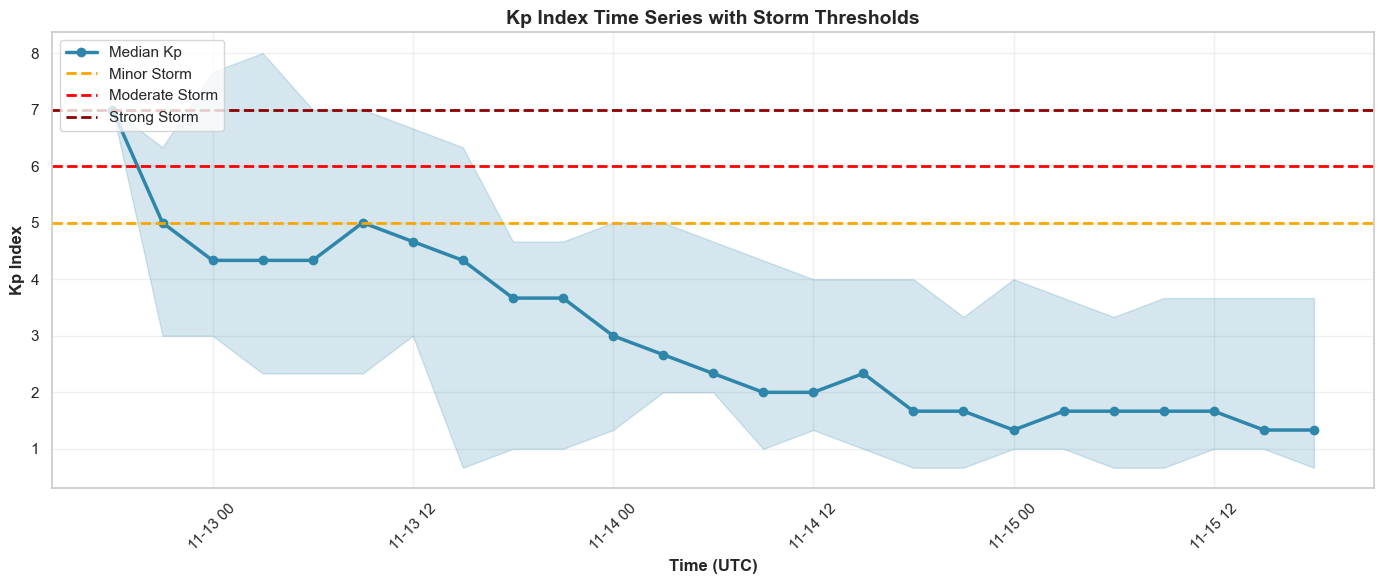

In [2]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_kp['Time (UTC)'], df_kp['median'], marker='o', linewidth=2.5, markersize=6, label='Median Kp', color='#2E86AB')
ax.fill_between(df_kp['Time (UTC)'], df_kp['minimum'], df_kp['maximum'], alpha=0.2, color='#2E86AB')
ax.axhline(y=5, color='orange', linestyle='--', linewidth=2, label='Minor Storm')
ax.axhline(y=6, color='red', linestyle='--', linewidth=2, label='Moderate Storm')
ax.axhline(y=7, color='darkred', linestyle='--', linewidth=2, label='Strong Storm')
ax.set_xlabel('Time (UTC)', fontsize=12, fontweight='bold')
ax.set_ylabel('Kp Index', fontsize=12, fontweight='bold')
ax.set_title('Kp Index Time Series with Storm Thresholds', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
os.makedirs('outputs/figures', exist_ok=True)
fig.savefig('outputs/figures/01_kp_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

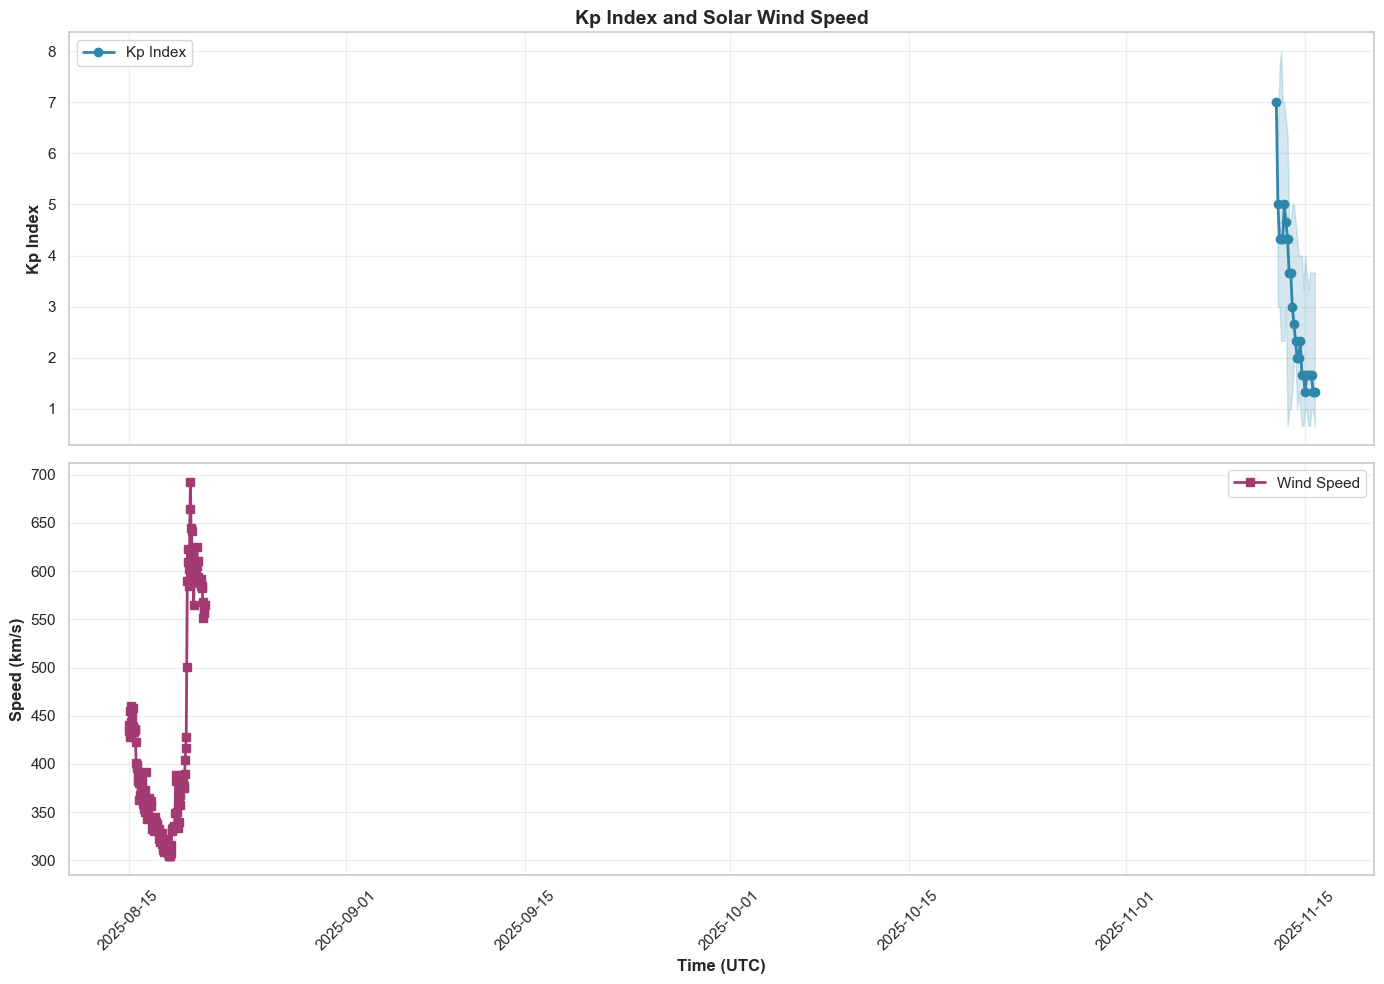

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax1.plot(df_merged['Time (UTC)'], df_merged['median'], marker='o', linewidth=2, color='#2E86AB', label='Kp Index')
ax1.fill_between(df_merged['Time (UTC)'], df_merged['minimum'], df_merged['maximum'], alpha=0.2, color='#2E86AB')
ax1.set_ylabel('Kp Index', fontweight='bold')
ax1.set_title('Kp Index and Solar Wind Speed', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax2.plot(df_merged['Time (UTC)'], df_merged['Speed'], marker='s', linewidth=2, color='#A23B72', label='Wind Speed')
ax2.set_xlabel('Time (UTC)', fontweight='bold')
ax2.set_ylabel('Speed (km/s)', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('outputs/figures/02_kp_vs_wind_speed.png', dpi=300, bbox_inches='tight')
plt.show()

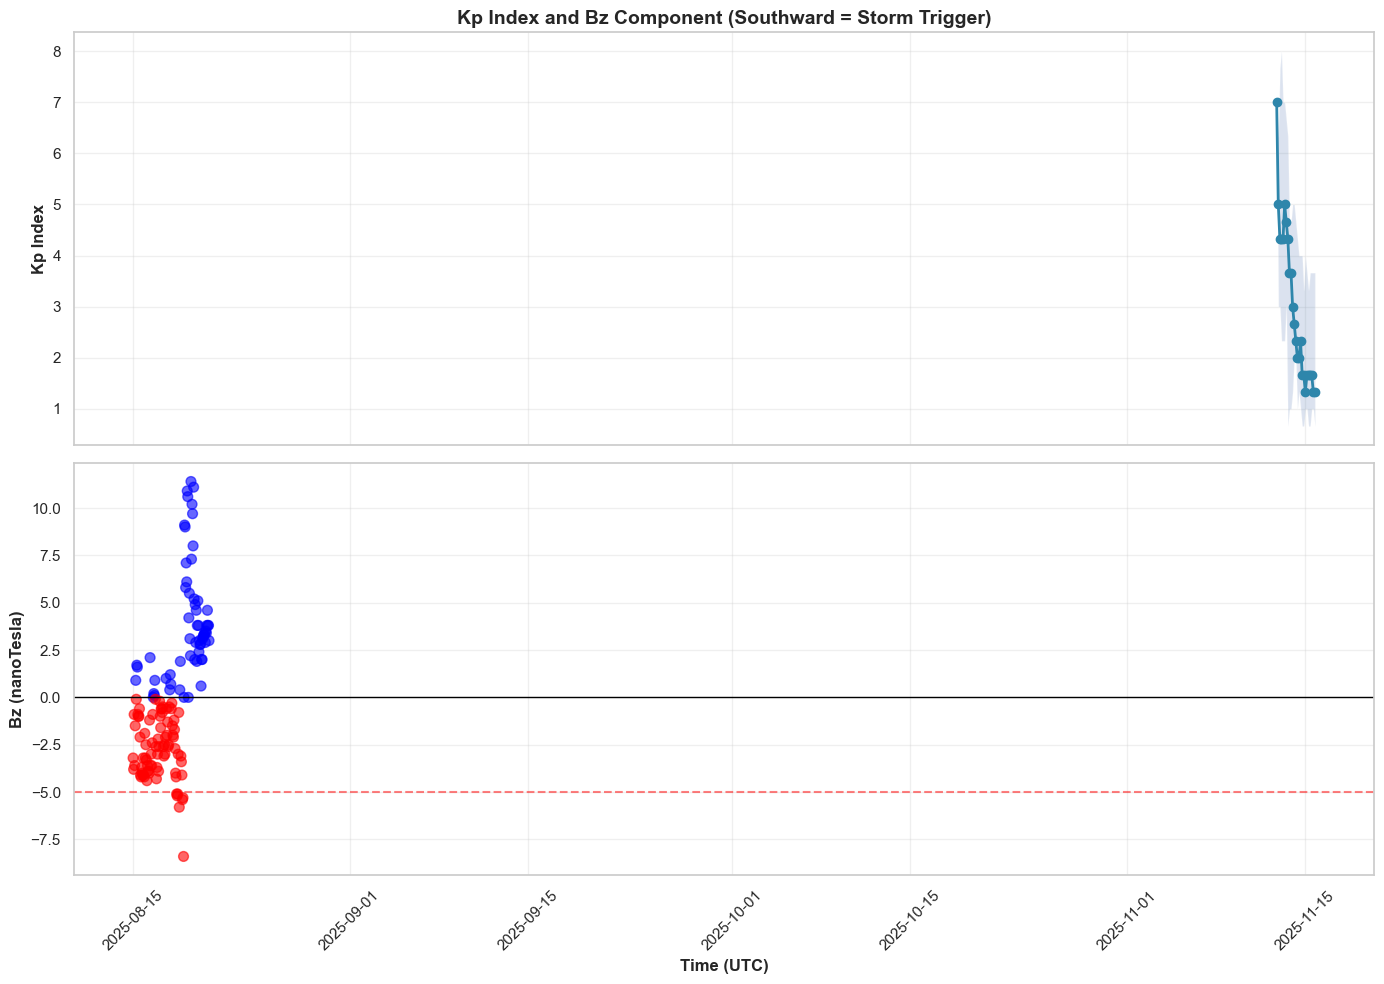

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax1.plot(df_merged['Time (UTC)'], df_merged['median'], marker='o', linewidth=2, color='#2E86AB')
ax1.fill_between(df_merged['Time (UTC)'], df_merged['minimum'], df_merged['maximum'], alpha=0.2)
ax1.set_ylabel('Kp Index', fontweight='bold')
ax1.set_title('Kp Index and Bz Component (Southward = Storm Trigger)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
colors = ['red' if x < 0 else 'blue' for x in df_merged['Bz']]
ax2.scatter(df_merged['Time (UTC)'], df_merged['Bz'], c=colors, s=50, alpha=0.6)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.axhline(y=-5, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Time (UTC)', fontweight='bold')
ax2.set_ylabel('Bz (nanoTesla)', fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig('outputs/figures/03_kp_vs_bz.png', dpi=300, bbox_inches='tight')
plt.show()

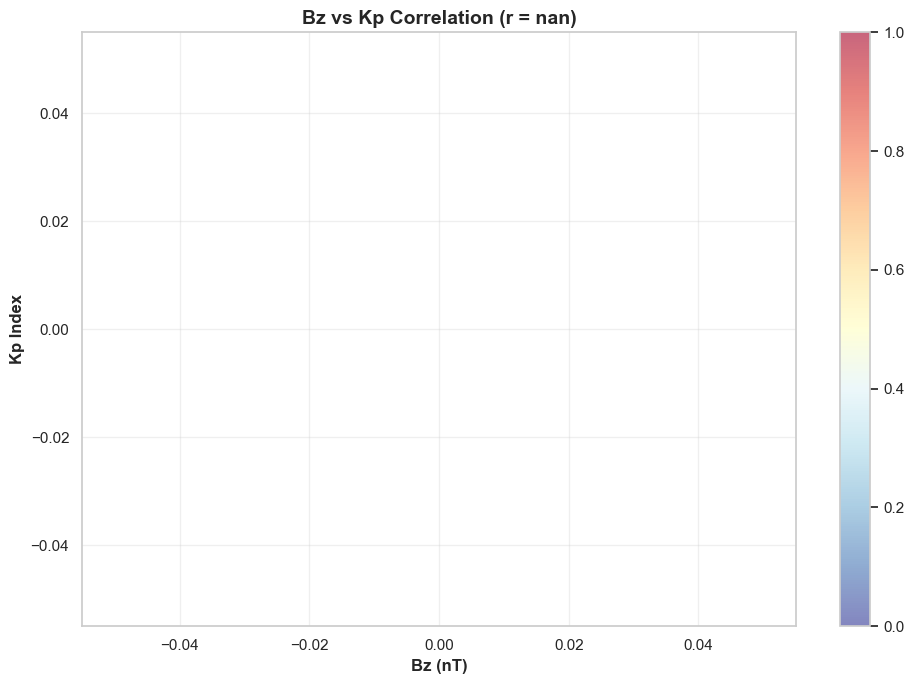

In [5]:
df_plot = df_merged[['median', 'Bz']].dropna()
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(df_plot['Bz'], df_plot['median'], s=100, alpha=0.6, c=df_plot['median'], cmap='RdYlBu_r', edgecolors='black')
corr = df_plot['Bz'].corr(df_plot['median'])
ax.set_xlabel('Bz (nT)', fontweight='bold')
ax.set_ylabel('Kp Index', fontweight='bold')
ax.set_title(f'Bz vs Kp Correlation (r = {corr:.3f})', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter)
plt.tight_layout()
fig.savefig('outputs/figures/04_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

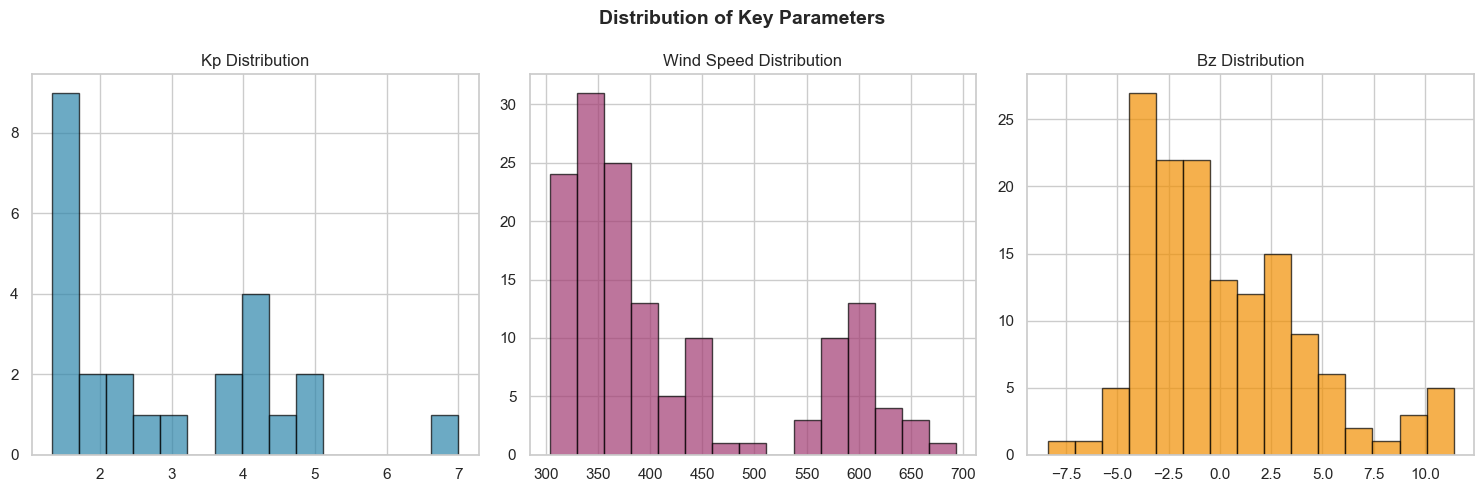

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(df_kp['median'].dropna(), bins=15, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[0].set_title('Kp Distribution')
axes[1].hist(df_solar['Speed'].dropna(), bins=15, color='#A23B72', alpha=0.7, edgecolor='black')
axes[1].set_title('Wind Speed Distribution')
axes[2].hist(df_solar['Bz'].dropna(), bins=15, color='#F18F01', alpha=0.7, edgecolor='black')
axes[2].set_title('Bz Distribution')
plt.suptitle('Distribution of Key Parameters', fontsize=14, fontweight='bold')
plt.tight_layout()
fig.savefig('outputs/figures/05_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
print('='*70)
print('PHASE 2 STATISTICS')
print('='*70)
print(f'Kp Mean: {df_kp["median"].mean():.2f}')
print(f'Storm events (Kp≥5): {(df_kp["median"] >= 5).sum()}')
print(f'Wind Speed Mean: {df_solar["Speed"].mean():.2f} km/s')
print(f'Bz Mean: {df_solar["Bz"].mean():.2f} nT')
corr_matrix = df_merged[['median', 'Speed', 'Bz']].corr()
print(f'Bz vs Kp Correlation: {corr_matrix.loc["Bz", "median"]:.4f}')

PHASE 2 STATISTICS
Kp Mean: 2.99
Storm events (Kp≥5): 3
Wind Speed Mean: 418.42 km/s
Bz Mean: 0.13 nT
Bz vs Kp Correlation: nan


In [8]:
os.makedirs('outputs/processed', exist_ok=True)
df_merged.to_csv('outputs/processed/space_weather_master.csv', index=False)
print('✓ Master dataset saved!')
print('Phase 2 Complete! Ready for Phase 3.')

✓ Master dataset saved!
Phase 2 Complete! Ready for Phase 3.
